In [4]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# mne library to analyse EEG
import mne
from mne import Epochs, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf
mne.set_log_level('error') # Avoid long log

In [5]:
# Create a list with each tipe of experimental run
openeye_runs = [1]
closedeye_runs = [2]
fists_runs = [3, 7, 11]
imaginefists_runs = [4, 8, 12]
fistsfeet_runs = [5, 9, 13]
imaginefistsfeet_run = [6, 10, 14]

# List with the ID of each participant
participants = [_ for _ in range(1,110)]


# Defining the EEG standard EEG bands. These are indicative situation in which we see appearing this type of waves on healty subjects.
delta_waves = {
    'freq_min': 0.5,
    'f_max': 4
} # normally occur during deep sleep

theta_waves = {
    'freq_min': 4,
    'freq_max': 8
} # transiently during sleep

alpha_waves = {
    'freq_min': 8, 
    'freq_max': 13
} # relaxed but awake state, resting with the eyes closed

beta_waves = {
    'freq_min': 13, 
    'freq_max': 30   
} # attention to tasks or stimuli,logical thinking

gamma_waves = {
    'freq_min': 30, 
    'freq_max': 70  
} # large-scale brain network activity and cognitive phenomena such as working memory, attention



In [6]:
# Charging the data
participant = 14

# Get the path to the data
def file_path(participant, run):
    return f'files/S{participant:03}/S{participant:03}R{run:02}.edf'

# Load the data
# Preload = True charges also the data, not just the headers
raw = concatenate_raws([read_raw_edf(file_path(participant, run), preload = True) for run in fists_runs])

In [9]:
# We choose the "Standard_1020" montage

montage = mne.channels.make_standard_montage("standard_1020")

# Here we change the names of the electrode to match the standard notation and set the choosen montage on the raw data charged.

# Dictionary with the structure old_name : correct_cases_name. To respect the upper and lower cases of the standard notation for the electrde's position.
replacement = {
    'Fc': 'FC',
    'Cp': 'CP',
    'Af': 'AF',
    'Ft': 'FT',
    'Tp': 'TP',
    'Po': 'PO'   
}

# new_name is the dictionary to use to cange the name of the electrode's positions to respect the usual sandard notataions.
# First get rid of the excessive "." 
new_names = {
    name : name.replace(".", "") for name in raw.info['ch_names']
}   

# Change the lower and upper case of the electrode's names
for key in new_names.keys():
    for old_string, new_string in replacement.items():
        new_names[key] = new_names[key].replace(old_string, new_string)

# Choose the montage and set it for the uploaded data
# montage = 'standard_1020'
raw.rename_channels(new_names)
raw.set_montage(montage)





<RawEDF | S014R03.edf, 64 x 59040 (369.0 s), ~28.9 MB, data loaded>

/home/elia/anaconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


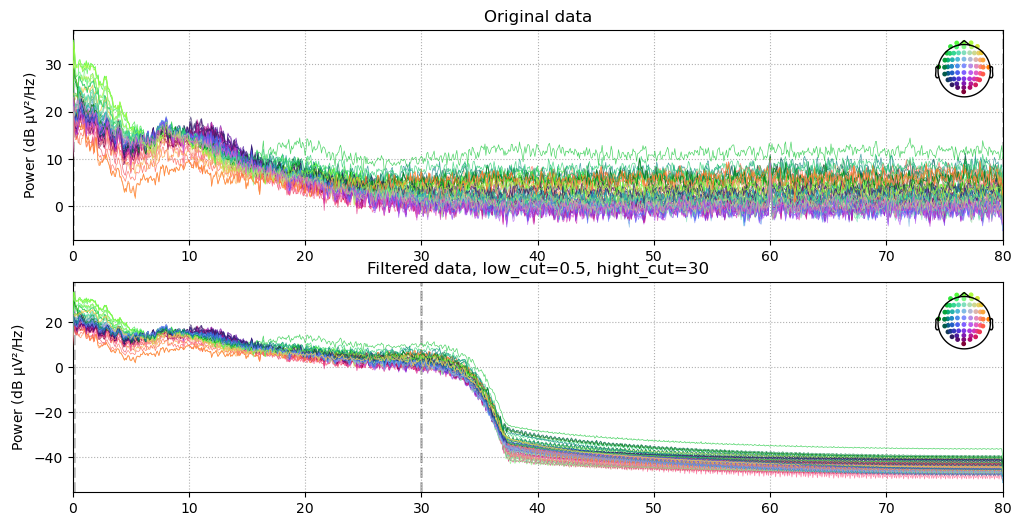

In [10]:
low_cut = 0.1 # We filter the low frequency to remove slow drift
high_cut = 30 # We filter the high frequency to eliminate noise, and because the motor signals appears mostly as alpha and beta waves

# copy the raw data and apply the filter
raw_filt = raw.load_data().copy().filter(low_cut, high_cut)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6)) 

raw.compute_psd().plot(axes = ax1)
ax1.set_title("Original data")

raw_filt.compute_psd().plot(axes = ax2)
ax2.set_title("Filtered data, low_cut=0.5, hight_cut=30")

plt.show()

The event_dict is:  {'T0': 1, 'T1': 2, 'T2': 3}


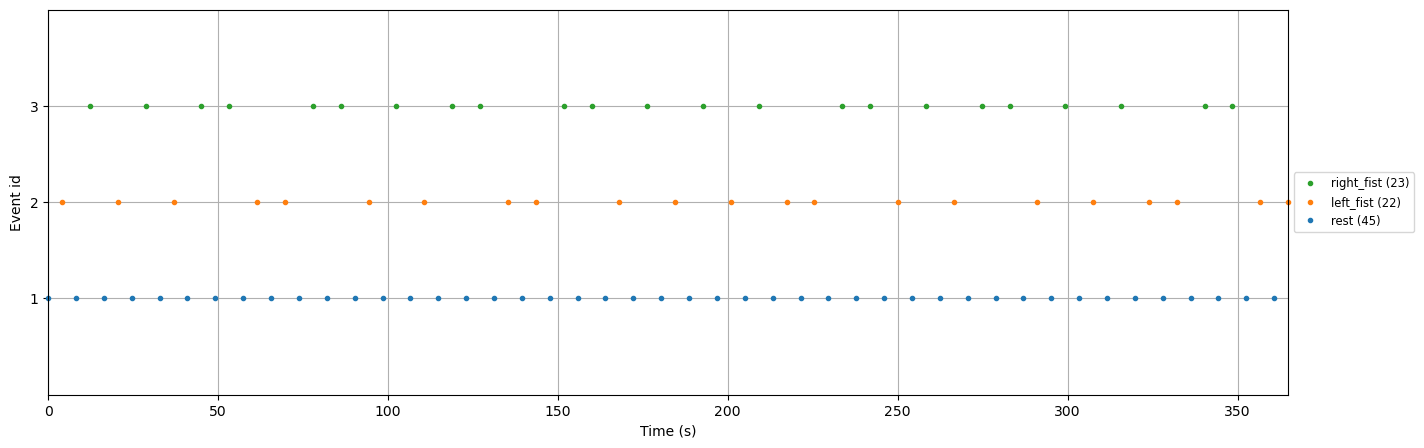

In [11]:
# Obtain the numpy array with the timing and the duration of each event and the dictionary with the name of the events.
# The timing is given as the number of the imput of the EEG. To get the time in second we need to multiplay it by the frequency 
# of the imput intake: 160Hz
events, events_dict = mne.events_from_annotations(raw_filt)
print('The event_dict is: ', events_dict)

# Making it easyer to read the events
event_mapping = {
    1: 'rest',
    2: 'left_fist',
    3: 'right_fist'
}
event_id = {v:k for k,v in event_mapping.items()}

# Drawing the distributon of the events
fig, ax = plt.subplots(figsize=[20, 5])
mne.viz.plot_events(events, raw_filt.info['sfreq'],  
                    event_id=event_id,                    
                    axes=ax)
plt.show()

In [12]:
events

array([[    0,     0,     1],
       [  656,     0,     2],
       [ 1312,     0,     1],
       [ 1968,     0,     3],
       [ 2624,     0,     1],
       [ 3280,     0,     2],
       [ 3936,     0,     1],
       [ 4592,     0,     3],
       [ 5248,     0,     1],
       [ 5904,     0,     2],
       [ 6560,     0,     1],
       [ 7216,     0,     3],
       [ 7872,     0,     1],
       [ 8528,     0,     3],
       [ 9184,     0,     1],
       [ 9840,     0,     2],
       [10496,     0,     1],
       [11152,     0,     2],
       [11808,     0,     1],
       [12464,     0,     3],
       [13120,     0,     1],
       [13776,     0,     3],
       [14432,     0,     1],
       [15088,     0,     2],
       [15744,     0,     1],
       [16400,     0,     3],
       [17056,     0,     1],
       [17712,     0,     2],
       [18368,     0,     1],
       [19024,     0,     3],
       [19680,     0,     1],
       [20336,     0,     3],
       [20992,     0,     1],
       [21

In [14]:
mne.events_from_annotations(raw_filt)[0]

array([[    0,     0,     1],
       [  656,     0,     2],
       [ 1312,     0,     1],
       [ 1968,     0,     3],
       [ 2624,     0,     1],
       [ 3280,     0,     2],
       [ 3936,     0,     1],
       [ 4592,     0,     3],
       [ 5248,     0,     1],
       [ 5904,     0,     2],
       [ 6560,     0,     1],
       [ 7216,     0,     3],
       [ 7872,     0,     1],
       [ 8528,     0,     3],
       [ 9184,     0,     1],
       [ 9840,     0,     2],
       [10496,     0,     1],
       [11152,     0,     2],
       [11808,     0,     1],
       [12464,     0,     3],
       [13120,     0,     1],
       [13776,     0,     3],
       [14432,     0,     1],
       [15088,     0,     2],
       [15744,     0,     1],
       [16400,     0,     3],
       [17056,     0,     1],
       [17712,     0,     2],
       [18368,     0,     1],
       [19024,     0,     3],
       [19680,     0,     1],
       [20336,     0,     3],
       [20992,     0,     1],
       [21

In [9]:
epoch_duration = 656. / raw_filt.info['sfreq']


# Epoching: We start the epochs 1 second before the onset signal
tmin =  -1.  # start of each epoch (in sec)
tmax =  4.1  # end of each epoch (in sec)
baseline = (-1, 0) # for the baseline correction we choose the interval that reflect the resting state before the event

# Create epochs
epochs = mne.Epochs(raw_filt,
                    events, event_id,
                    tmin = tmin,
                    tmax = tmax,
                    preload=True,
                    baseline = baseline
                   ) 

print(epochs.drop_log)

(('NO_DATA',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('BAD boundary',), ('BAD boundary',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('BAD boundary',), ('BAD boundary',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('TOO_SHORT',))


In [12]:
# Load necessary libraries
import mne
from mne.decoding import Vectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression


In [14]:
data_UN = epochs.get_data()
labels_UN = epochs.events[:,-1]

In [17]:
train_data_UN, test_data_UN, labels_train_UN, labels_test_UN = train_test_split(data_UN, labels_UN, test_size=0.3, random_state=42)


In [21]:
labels_train_UN

array([1, 1, 1, 3, 3, 1, 2, 3, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 2, 2, 2,
       3, 3, 1, 1, 2, 2, 2, 1, 1, 1, 2, 3, 3, 1, 3, 1, 1, 2, 1, 1, 1, 3,
       1, 1, 1, 2, 1, 3, 1, 3, 2, 3, 2, 1, 2, 1])

In [18]:
clf_svm_0 = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(kernel='rbf', C=1))
scores = cross_val_score(clf_svm_0, data_UN, labels_UN, cv=5)
for i in range(len(scores)):   
    print('Accuracy of ' + str(i+1) + 'th fold is ' + str(scores[i]) + '\n')


Accuracy of 1th fold is 0.47058823529411764

Accuracy of 2th fold is 0.5294117647058824

Accuracy of 3th fold is 0.5294117647058824

Accuracy of 4th fold is 0.47058823529411764

Accuracy of 5th fold is 0.5



In [19]:
#svm
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42))
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True)


In [20]:
gs_cv_svm.fit(train_data_UN, labels_train_UN)
print('Best Parameters: {}'.format(gs_cv_svm.best_params_))
print('Best Score: {}'.format(gs_cv_svm.best_score_))


Best Parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best Score: 0.656060606060606


In [25]:
#Prediction
predictions_svm = gs_cv_svm.predict(test_data_UN)

#Evaluate
report_svm = classification_report(labels_test_UN, predictions_svm, target_names=['rest', 'left', 'right'])
print('SVM Clasification Report:\n {}'.format(report_svm))

acc_svm = accuracy_score(labels_test_UN, predictions_svm)
print("Accuracy of SVM model: {}".format(acc_svm))

precision_svm,recall_svm,fscore_svm,support_svm=precision_recall_fscore_support(labels_test_UN,predictions_svm,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_svm,recall_svm,fscore_svm))


SVM Clasification Report:
               precision    recall  f1-score   support

        rest       0.48      1.00      0.65        11
        left       1.00      0.29      0.44         7
       right       1.00      0.12      0.22         8

    accuracy                           0.54        26
   macro avg       0.83      0.47      0.44        26
weighted avg       0.78      0.54      0.46        26

Accuracy of SVM model: 0.5384615384615384
Precision: 0.8260869565217391, Recall: 0.4702380952380952, f1-score:0.4379084967320262


In [26]:
predictions_svm

array([1, 2, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [27]:
# Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(random_state=42))
parameters = {'logisticregression__penalty':['l1', 'l2']}
gs_cv_lr = GridSearchCV(clf_lr_pip, parameters, scoring='accuracy')
gs_cv_lr.fit(train_data_UN, labels_train_UN)

print('Best Parameters: {}'.format(gs_cv_lr.best_params_))
print('Best Score: {}'.format(gs_cv_lr.best_score_))

#Predictions
predictions_lr = gs_cv_lr.predict(test_data_UN)

#Evaluation
report_lr = classification_report(labels_test_UN, predictions_lr, target_names=['rest', 'left', 'right'])
print('LR Clasification Report:\n {}'.format(report_lr))

acc_lr = accuracy_score(labels_test_UN, predictions_lr)
print("Accuracy of LR model: {}".format(acc_lr))

precision_lr,recall_lr,fscore_lr,support_lr=precision_recall_fscore_support(labels_test_UN,predictions_lr,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lr,recall_lr,fscore_lr))


/home/elia/anaconda3/envs/mne/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/elia/anaconda3/envs/mne/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/elia/anaconda3/envs/mne/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/elia/anaconda3/envs/mne/lib/python3.12/site-packages/sklear

Best Parameters: {'logisticregression__penalty': 'l2'}
Best Score: 0.5424242424242425
LR Clasification Report:
               precision    recall  f1-score   support

        rest       0.45      0.82      0.58        11
        left       0.60      0.43      0.50         7
       right       1.00      0.12      0.22         8

    accuracy                           0.50        26
   macro avg       0.68      0.46      0.43        26
weighted avg       0.66      0.50      0.45        26

Accuracy of LR model: 0.5
Precision: 0.6833333333333332, Recall: 0.45725108225108224, f1-score:0.43428912783751494


In [28]:
predictions_lr

array([1, 2, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 1])

In [29]:
# Linear Discriminant Analysis
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
clf_lda_pip.fit(train_data_UN,labels_train_UN)

#Predictions
predictions_lda = clf_lda_pip.predict(test_data_UN)

#Evaluation
report_lda = classification_report(labels_test_UN, predictions_lda, target_names=['rest', 'left', 'right'])
print('LDA Clasification Report:\n {}'.format(report_lda))

acc_lda = accuracy_score(labels_test_UN, predictions_lda)
print("Accuracy of LDA model: {}".format(acc_lda))

precision_lda,recall_lda,fscore_lda,support_lda=precision_recall_fscore_support(labels_test_UN,predictions_lda,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lda,recall_lda,fscore_lda))


LDA Clasification Report:
               precision    recall  f1-score   support

        rest       0.40      0.91      0.56        11
        left       0.00      0.00      0.00         7
       right       0.00      0.00      0.00         8

    accuracy                           0.38        26
   macro avg       0.13      0.30      0.19        26
weighted avg       0.17      0.38      0.24        26

Accuracy of LDA model: 0.38461538461538464
Precision: 0.13333333333333333, Recall: 0.30303030303030304, f1-score:0.1851851851851852


/home/elia/anaconda3/envs/mne/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elia/anaconda3/envs/mne/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elia/anaconda3/envs/mne/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [30]:
predictions_lda

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1])

In [31]:
accuracies, f1_scores = [], []
accuracies.append([acc_svm, acc_lr, acc_lda])
f1_scores.append([fscore_svm, fscore_lr, fscore_lda])
